# __[:+:]__ SBERT Embeddings Test

In [142]:
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import plotly.express as px
from umap import UMAP
import pandas as pd
import numpy as np
import umap.plot
import pickle
import json

### Get Data

In [143]:
with open("ideological_corpus.txt", "r") as f:
    corpus = f.readlines()
print("[+] -- Loaded ", len(corpus), ' docs ---------------------------------------------------------------------------------------------|')
for i in range(3):
    print(i, ': ', corpus[i])

with open("transcript.txt", "r") as f:
    transcript = f.readlines()
print("[+] -- Loaded ", len(transcript), ' docs ---------------------------------------------------------------------------------------------|')
for i in range(3):
    print(i, ': ', transcript[i])

# Read csv of generated reference opinions as dataframe
refCluster_df = pd.read_csv('referenceClusters_200.csv')
print(' ---------------------------------------------------------------------------------------------|\n', refCluster_df.head(), '\n')

[+] -- Loaded  70  docs ---------------------------------------------------------------------------------------------|
0 :  Support for Israeli settlements in the West Bank is crucial for security.

1 :  Palestinian statehood should be recognized and supported by the international community.

2 :  Economic cooperation between Israel and Palestine can lead to peace.

[+] -- Loaded  238  docs ---------------------------------------------------------------------------------------------|
0 :  Speaker 1 [0.01s - 26.53s]:  You're saying that you think it's the two narratives. Yeah, but we can't hear you very loudly. Maybe it's much better, much better.

1 :  Speaker 3 [4.60s - 25.21s]:  Yeah, I was just saying that I think it's pretty obvious why Native Americans would side with Palestinians. I didn't really know that there were Palestinians, that there were Native Americans who were pro-Israel. Sorry, is this better?

2 :  Speaker 3 [26.65s - 39.19s]:  Yeah, I was just saying that I'm not s

### Load Model and Embed 
Choose and load model from https://sbert.net/docs/sentence_transformer/pretrained_models.html

In [144]:
#[+:]-- Top quality for general purpose
model = SentenceTransformer('all-mpnet-base-v2')

#[+:]-- Smaller, faster, but decent quality
# model = SentenceTransformer('all-MiniLM-L6-v2')

#Embed some examples
emb1 = model.encode("This is a red cat with a hat.")
emb2 = model.encode("Have you seen my red cat?")

#Get the cosine similarity score between example sentences
cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.6053]])


In [145]:
# corpusEmb_arr= [model.encode(i) for i in corpus]
# print(len(corpusEmb_arr), len(corpusEmb_arr[0]))

#[+:] extract only the sentences, (without the labels)
sentences = refCluster_df.loc[:,'opinion']
print('\nOpinion Sentences sans Labels: \n', sentences.head(), '\n', len(sentences))

#[+:] Embed the extracted sentences
# sent_emb= [model.encode(i) for i in sentences]
sent_emb = model.encode(sentences, show_progress_bar=True)
print('Embeded Sentences: ', len(sent_emb),'x', len(sent_emb[0]))


Opinion Sentences sans Labels: 
 0    Israel has the right to exist as a sovereign J...
1    Israel's security measures are necessary to pr...
2    The Israeli government's efforts to negotiate ...
3    Israel's withdrawal from Gaza in 2005 was a si...
4    Hamas' use of civilian areas for launching att...
Name: opinion, dtype: object 
 198


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Embeded Sentences:  198 x 768


### UMAP Dimensionality Reduction & Visualization

#### 2D Projection

In [146]:

#[+] Also try "metric= cosine" arg for UMAP
# umapper_2d= UMAP(n_components= 2, init= 'random', random_state=0, metric='cosine')
# proj_2d= umapper_2d.fit_transform(corpusEmb_arr)
# fig_2d= px.scatter(proj_2d, x=0, y=1)
# fig_2d.show()

#### 3D Projection

In [147]:
#[+]-- UMAP on corpus
# umapper_3d= UMAP(n_components= 3, init= 'random', random_state=0, metric='cosine')
# proj_3d= umapper_3d.fit_transform(corpusEmb_arr)
# fig_3d= px.scatter_3d(proj_3d, x=0, y=1, z=2)
# fig_3d.update_traces(marker_size=7)
# fig_3d.show()

#[+]-- UMAP on generated opinions
# umap_3d = UMAP(n_components=3, init='random', random_state=0, metric='cosine')
# proj_3d = umap_3d.fit_transform(sent_emb)
# print(len(proj_3d), len(proj_3d[0]))
# fig_3d = px.scatter_3d(
#     proj_3d,
#     x=0, y=1, z=2,
#     color=refCluster_df.stance, 
#     labels={'color': 'stance'}
# )
# fig_3d.update_traces(marker_size=5)
# fig_3d.show()



#[+] Project all the embeddings into 3d
umap_3d = UMAP(n_components=3, init='random', random_state=0, metric='cosine')
proj_3d = umap_3d.fit_transform(sent_emb)

#[+] Create a new dataframe where each sentence is not the sentence embedding projection
proj_3d_df= pd.DataFrame(proj_3d, columns= ['x', 'y', 'z'])
proj_3d_df['stance'] = refCluster_df.stance
proj_3d_df['index'] = refCluster_df.index
print(proj_3d_df.head(), '\n')

#[+] Sanity Check
for i in range(99,101): print(proj_3d_df.iloc[i], '\n')
print(type(proj_3d),'\n', proj_3d[99:101])


#[+] Map the dataframe of projected embeddings in 3d
fig_3d = px.scatter_3d(
    proj_3d_df,
    x='x', y='y', z='z',
    color='stance', 
    #labels={'color': 'stance'}
    hover_data= 'index',
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

          x         y         z      stance  index
0  6.517374  2.675528  2.756611  pro-Israel      0
1  6.934030  2.352883  3.922823  pro-Israel      1
2  1.513688  3.876531  2.456818  pro-Israel      2
3  8.630718  1.361171  2.381235  pro-Israel      3
4  6.115170  3.002205  3.773715  pro-Israel      4 

x            9.17708
y           0.704991
z            2.74309
stance    pro-Israel
index             99
Name: 99, dtype: object 

x              1.799104
y              4.465894
z              3.633391
stance    pro-Palestine
index               100
Name: 100, dtype: object 

<class 'numpy.ndarray'> 
 [[9.17708   0.704991  2.7430902]
 [1.7991043 4.4658937 3.633391 ]]


## Take the Average of Each Embedding Cluster

In [148]:
pro_isr= refCluster_df[refCluster_df['stance']== "pro-Israel"]
pro_isr= pro_isr.loc[:,'opinion']
for i in range(5): print(pro_isr.iloc[i])
pro_isr_emb= np.array([model.encode(i) for i in pro_isr])
print(pro_isr_emb.shape)
pro_isr_avg= np.mean(pro_isr_emb, axis=0)
print(pro_isr_avg.shape)

Israel has the right to exist as a sovereign Jewish state.
Israel's security measures are necessary to protect its citizens from terrorism.
The Israeli government's efforts to negotiate peace have been met with consistent rejection from Palestinian leadership.
Israel's withdrawal from Gaza in 2005 was a significant concession aimed at fostering peace.
Hamas' use of civilian areas for launching attacks justifies Israel's self-defense actions.
(100, 768)
(768,)


In [149]:
pro_pal= refCluster_df[refCluster_df['stance']== "pro-Palestine"]
pro_pal= pro_pal.loc[:,'opinion']
print(pro_pal.head())
pro_pal_emb= np.array([model.encode(i) for i in pro_pal])
print(pro_pal_emb.shape)
pro_pal_avg= np.mean(pro_pal_emb, axis=0)
print(pro_pal_avg.shape)

100    Israel's continued expansion of settlements in...
101    The Israeli blockade of Gaza has created a hum...
102    Israel's use of disproportionate force in Gaza...
103    The Israeli government's refusal to engage in ...
104    Israel's occupation of Palestinian territories...
Name: opinion, dtype: object
(98, 768)
(768,)


### Find Nearest Cluster for a given Opinion

In [150]:
opinion= "Israel has the right to defend itself against Hamas"
opinion_emb= model.encode(opinion)
print('Opinion Embedding Shape: ', opinion_emb.shape)

umap_3d = UMAP(n_components=3, init='random', random_state=0, metric='cosine')
proj_3d = umap_3d.fit_transform([pro_isr_avg, pro_pal_avg, opinion_emb])
print('Embedded: \n', proj_3d)

proj_3d_df= pd.DataFrame(proj_3d, columns= ['x', 'y', 'z'])
proj_3d_df['stance'] = ['pro-IS', 'pro-PS', 'Opinion']
print('proj_3d_df:', proj_3d_df)


fig_3d = px.scatter_3d(
    data_frame= proj_3d_df,
    x='x', y='y', z='z',
    color='stance', 
    text= 'stance'
    #labels={'color': np.array(mapping.keys())}
)
fig_3d.update_traces(marker_size=10)
fig_3d.show()

#Get the cosine similarity score between the opnion and the two clusters
cos1 = util.cos_sim(opinion_emb, pro_isr_avg)
cos2 = util.cos_sim(opinion_emb, pro_pal_avg)
if cos1>cos2:
    print(opinion, ": [pro Israel] |  ", cos1)
elif cos1<cos2:
    print(opinion, ": [pro Palestine] | ", cos2)
else: 
    print(opinion, ": [neutral] | ")

Opinion Embedding Shape:  (768,)
Embedded: 
 [[12.068358   2.5732822  0.0904668]
 [11.545877   2.0999937  0.6146024]
 [12.493799   3.0207074  0.9170205]]
proj_3d_df:            x         y         z   stance
0  12.068358  2.573282  0.090467   pro-IS
1  11.545877  2.099994  0.614602   pro-PS
2  12.493799  3.020707  0.917020  Opinion


Israel has the right to defend itself against Hamas : [pro Israel] |   tensor([[0.7168]])


## Topic Modelling

In [151]:
from bertopic import BERTopic
import json

# The model used for topics comes from BERTopic, not SBERT apparently
topic_model= BERTopic(embedding_model= 'all-MiniLM-L6-v2' )
probs, topics= topic_model.fit_transform(sentences)


In [152]:
topic_df= pd.DataFrame({"topic": topics, "sentence": sentences })
print(topic_df.head())
topic_model.visualize_topics()


      topic                                           sentence
0  0.000000  Israel has the right to exist as a sovereign J...
1  1.000000  Israel's security measures are necessary to pr...
2  0.987881  The Israeli government's efforts to negotiate ...
3  0.898899  Israel's withdrawal from Gaza in 2005 was a si...
4  0.861934  Hamas' use of civilian areas for launching att...


In [153]:
topic_model.visualize_barchart()

In [154]:
# for i in topic_model.get_topic_info(): print(i)
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,51,-1_palestinian_the_israel_international,"[palestinian, the, israel, international, to, ...",[The international community should do more to...
1,0,41,0_global_government_israel_israeli,"[global, government, israel, israeli, and, the...",[The Israeli government has been a consistent ...
2,1,26,1_the_bank_west_of,"[the, bank, west, of, policies, expansion, isr...",[The Israeli government's policies in the West...
3,2,23,2_military_actions_often_in,"[military, actions, often, in, palestinian, ci...",[The Israeli military’s use of force against P...
4,3,22,3_peace_refusal_to_leadership,"[peace, refusal, to, leadership, palestinian, ...",[Palestinian refusal to recognize Israel's rig...
5,4,12,4_gaza_blockade_of_severe,"[gaza, blockade, of, severe, crisis, humanitar...",[The ongoing violence in Gaza has led to a sev...
6,5,12,5_palestinians_occupation_palestinian_the,"[palestinians, occupation, palestinian, the, r...",[The Palestinian cause for liberation is a str...
7,6,11,6_its_citizens_right_security,"[its, citizens, right, security, israel, defen...",[Israel's right to defend its citizens is para...


### Topic Modelling P2
https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

#### Clustering + Dimensionality Reduction
"We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly."

In [155]:
import hdbscan

#[+] We have already embedded to topics usinga better model from the same SBERT library
# topic_model2 = SentenceTransformer('distilbert-base-nli-mean-tokens')
# sent_emb2 = model.encode(sentences, show_progress_bar=True)

nhood= 15

proj_5d = umap.UMAP(n_neighbors= nhood, 
                    n_components=5, 
                    metric='cosine').fit_transform(sent_emb)

cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(proj_5d)

print('cluster labels: ', set(cluster.labels_), len(set(cluster.labels_)))

cluster labels:  {0, 1, 2, 3, 4, 5, 6, 7, -1} 9


#### Visualize

           x         y  labels
0   8.384400  0.791540      -1
1   7.542162  1.164020       7
2  12.369984  3.971121       2
3   7.287386 -0.846808       0
4   8.080837  2.040849       7 
 (198, 3)


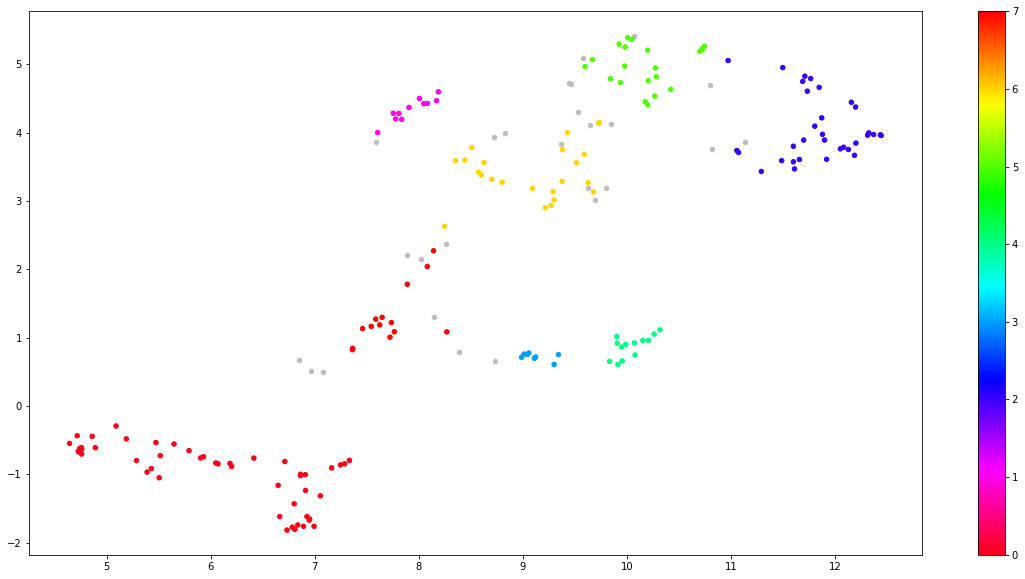

In [156]:
# Prepare data
proj_2d_2 = umap.UMAP(n_neighbors=nhood, 
                      n_components=2, 
                      min_dist=0.0, 
                      metric='cosine').fit_transform(sent_emb)

res_df = pd.DataFrame(proj_2d_2, columns=['x', 'y'])
res_df['labels'] = cluster.labels_
print(res_df.head(), '\n',res_df.shape)

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = res_df.loc[res_df.labels == -1, :]
clustered = res_df.loc[res_df.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=20)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=20, cmap='hsv_r')
plt.colorbar()

#### c-TF-IDF

In [169]:
# Group sentences together based on topic
snt_df= pd.DataFrame(sentences)
snt_df['Topic']= cluster.labels_
snt_df['idx']= range(len(snt_df))
snt_df.head()
snt_per_topic = snt_df.groupby(['Topic'], as_index = False).agg({'opinion': ' '.join})
print(snt_per_topic.iloc)

Topic                                                     -1
opinion    Israel has the right to exist as a sovereign J...
Name: 0, dtype: object


## TODO
- [+] Install packages
- [+] Embed corpus lines
- [+] UMAP Dim reduction
- [+] Get the Average Embeddign for the Cluster, and compare 
- [ ] Do Cos similarity without dim reduction
- [ ] Explore different sentence transformers models
- [ ] Explore clustering methods (read documentation)
- [ ] Embed LLM-generated polarized opinions as references
- [ ] Try other dimensionality reduction techiques
- [ ] IDEA: Given two opposing embeddings of people, do Topic Modelling on their nearest neighbors to find out the points that they disagree on


## Possible Ideas
-   Recreate Lupin: Classify embedding within a spectrum between two polar opposite references
-   KNN-based algo: instead of using a spectrum, simply classify each opinion based on its nearest neighbors in vector space, or some variation of that
    - Given the sometimes ambiguous and overlapping nature of ideologies, this might be used as an alternative to classifying based on discrete categories
    - ex: "given this person's opinion, he is most ideologically aligned with politicians x and y"
    - We could also create an embedding of entire ideology as an average of a collection of quotes, and do classification based on the single nearest neighbor

-   Recreate the 2019 Party Embedding method using SBERT
    - Embed each opinion in the dataset with a party/ideology label
    - Classify each new opinion based on distance to that label (need more research to confirm this method)